# SCA 6.1 - The S1A Serine Proteases

**Summary:**  This script repeats the analysis of the S1A serine protease family, an example of a single protein containing at least three independent sectors. This analysis starts from the alignment used in:

    -  Halabi, Rivoire, Leibler and Ranganathan. (2009) Cell 138:774-786.
    
The goal is to examine the output of the pySCA (v6) analysis for the comparison to earlier results. In the S1A serine protease family, prior results indicate three sectors: "red" - associated with catalytic specificity, "green" - associated with catalytic function (the catalytic triad), and "blue" - associated with stability. 

To facilitate comparison, here are the S1A sector definitions as described in Halabi et al. in a format suitable for pasting into pyMol:

    ** Red:**   17+161+172+176+177+180+183+187+188+189+191+192+213+215+216+220+221+226+227+228
    ** Green:** 19+33+42+43+55+56+57+58+102+141+142+184+194+195+196+197+198+199+213+214+216+225
    ** Blue:** 21+26+46+52+68+69+71+77+80+81+104+105+108+118+123+124+136+153+157+201+210+229+237+242+245

Prior to running this tutorial, the core calculation scripts must be executed from the command line as follows:

    >> scaProcessMSA -a ../data/s1Ahalabi_1470_nosnakes.an -b ../data/ -s 3TGI -c E -t -n
    >> scaCore -i ../output/s1Ahalabi_1470_nosnakes.db
    >> scaSectorID -i ../output/s1Ahalabi_1470_nosnakes.db

Note that we supply pre-annotated alignments for all tutorial scripts *(the annotate_pfMSA step is slow, and should only be run once)*.

**O.Rivoire, K.Reynolds and R.Ranganathan**
10/2015

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy.cluster.hierarchy as sch
from scipy.stats import scoreatpercentile 
import matplotlib.image as mpimg
from IPython.display import display
from IPython.display import Image
from Bio.Seq import Seq
from Bio import motifs
import colorsys
from pysca import scaTools as sca
#import mpld3
import pickle as pickle
from optparse import OptionParser

%matplotlib inline

if not os.path.exists('../output/'):
    os.makedirs('../output/')  

To begin, we read in the results of the above three scripts (scaProcessMSA, scaCore and scaSectorID), stored as three dictionaries in the database s1Ahalabi_1470_nosnakes.db  

In [2]:
db = pickle.load(open('../output/s1Ahalabi_1470_nosnakes.db','rb'))
Dseq = db['sequence']  #the results of scaProcessMSA
Dsca = db['sca']       #the results of scaCore
Dsect = db['sector']   #the results of scaSectorID

### I. Alignment processing and composition

First, we print out a few statistics describing the alignment:

In [3]:
print("After processing, the alignment size is %i sequences and %i positions" % \
      (Dseq['Nseq'], Dseq['Npos']))
print("With sequence weights, there are %i effective sequences" % (Dseq['effseqs']))

After processing, the alignment size is 1344 sequences and 205 positions
With sequence weights, there are 928 effective sequences


To examine alignment composition, we plot a histogram of all pairwise sequence identities *(left panel)* and a global view of the sequence similarity matrix (defined by $S\equiv \frac{1}{L}XX^\top$) *(right panel)*.  The data show that the alignment is described by a nearly homogeneous distribution of sequence identities with a mean value of about 30%.

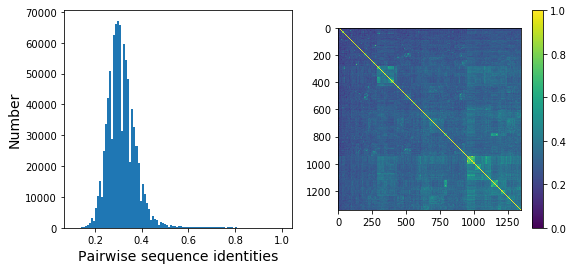

In [4]:
# List all elements above the diagonal (i<j):
listS = [Dsca['simMat'][i,j] for i in range(Dsca['simMat'].shape[0]) \
         for j in range(i+1, Dsca['simMat'].shape[1])]

# Cluster the sequence similarity matrix
Z = sch.linkage(Dsca['simMat'], method = 'complete', metric = 'cityblock')
R = sch.dendrogram(Z, no_plot = True)
ind = R['leaves']

# Plotting
plt.rcParams['figure.figsize'] = 9, 4 
plt.subplot(121)
plt.hist(listS, int(round(Dseq['Npos']/2)))
plt.xlabel('Pairwise sequence identities', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(122)
plt.imshow(Dsca['simMat'][np.ix_(ind,ind)], vmin=0, vmax=1); plt.colorbar();

**Sequence annotations:**  We construct a dictionary of phylogenetic annotations (parsed from the sequence headers) and check the representation of sequences in the top taxonomic levels. For each level, we print a list of taxonomic classes, and the number of sequences found for each. We also construct dictionaries of annotations for vertebrate vs. non vertebrate sequences, and substrate specificity (to later be used when mapping to sequence space). We print a list of common specificities following the list of taxonomic classes.

In [5]:
#construct a dictionary of phylogenetic groups
annot = dict()
spec = dict()
vert = dict()
vert['vertebrate'] = []
vert['not vertebrate']= []
for i, h in enumerate(Dseq['hd']):
    s1 = h.split('__')
    s2 = s1[0].split('|')
    hs = s1[1].split('|')
    tax = []
    annot[s2[1]] = sca.Annot(s1[0], hs[2], ','.join(hs[3:-2]))
    if (hs[-2] in spec):
        spec[hs[-2]].append(i)
    else:
        spec[hs[-2]] = [i]
    if hs[0] == 'vertebrate':
        vert[hs[0]].append(i)
    else:
        vert['not vertebrate'].append(i)        
    
# Most frequent taxonomic groups:
atleast = 10
for level in range(3):
    descr_list = [a.taxo.split(',')[level] for a in annot.values() \
                  if len(a.taxo.split(',')) > level]
    descr_dict = {k:descr_list.count(k) for k in descr_list \
                  if descr_list.count(k)>=atleast}
    print('\n Level %i:' % level)
    print(descr_dict)
    
# Most frequent catalytic specificities:  
print('\nCatalytic Specificities: ')
for k in spec.keys():
    if len(spec[k]) > 5:
        print(k+': '+str(len(spec[k])))


 Level 0:
{'Mammalia': 447, 'Insecta': 564, 'Actinopterygii': 127, 'Arachnida': 25, 'Actinobacteria (class)': 14, 'Malacostraca': 12, 'Amphibia': 58, 'Oligochaeta': 11}

 Level 1:
{'Rodentia': 174, 'Diptera': 391, 'Lepidoptera': 59, 'Carnivora': 45, 'Ruminantia': 61, 'Tetraodontiformes': 19, 'Coleoptera': 81, 'Astigmata': 23, 'Actinomycetales': 14, 'Primates': 142, 'Decapoda': 12, 'Anura': 58, 'Cypriniformes': 60, 'Hymenoptera': 15, 'Haplotaxida': 11, 'Perciformes': 12, 'Laurasiatheria': 14, 'Pleuronectiformes': 14}

 Level 2:
{'Muridae': 170, 'Culicidae': 153, 'Drosophilidae': 203, 'Noctuidae': 28, 'Canidae': 44, 'Bovidae': 61, 'Tetraodontidae': 19, 'Tenebrionidae': 70, 'Sarcoptidae': 14, 'Hominidae': 129, 'Pipidae': 58, 'Cyprinidae': 60, 'Apidae': 10, 'Streptomycetaceae': 12, 'Lumbricidae': 11, 'Suidae': 14, 'Paralichthyidae': 12, 'Cercopithecidae': 11}

Catalytic Specificities: 
trypsin: 182
ELSE: 611
granzyme: 52
chymotrypsin: 85
chymase: 8
allergen: 21
mast cell protease: 24
hapt

Based on this, we select both taxonomic groups and specificity classes, and associate them to colors for representation.  We choose broad taxonomic groups (corresponding to Level 1), and well-populated specificity classes that are well-represented in the alignment . To see a complete legend that maps numeric codes to color, use: 
    
    >>> sca.figColors()
    
We start with taxonomic groups:

In [6]:
phylo = list();
fam_names = ['Oligochaeta', 'Malacostraca','Actinopterygii','Actinobacteria',\
            'Mammalia','Amphibia','Insecta','Arachnida']
col = (0,0.12,0.18,0.38,0.5,0.60,0.78,0.90) 
#Oligochaeta = red, Malacostraca = orange, Actinopterygii = yellow, 
#Actinobacteria = green, Mammalia = cyan, Amphibia = dark blue,
#Insecta = purple, Arachnida = bright pink
for i,k in enumerate(fam_names):
    sf = sca.Unit()
    sf.name = fam_names[i].lower()
    sf.col = col[i]
    sf.items = [j for j,q in enumerate(Dseq['hd'])  if sf.name in q.lower()]
    phylo.append(sf)

Now we assign substrate specificity classes, and also sort sequences into catalytically active and inactive enzymes (the haptoglobins).

In [7]:
spec_names = ['chymotrypsin','trypsin','tryptase', 'kallikrein', 'granzyme']
cat_act = ['active','haptoglobin']
col_spec = [0,0.12,0.38,0.5,0.60,0.9]
#chymotrypsin = red, trypsin = orange, tryptase = green, 
#kallikrein = cyan, granzyme = bright pink
col_vert = [0.12, 0.5]
#vertebrates = orange, invertebrates = cyan
col_act = [0.65,0.5]
#active = blue, inactive (haptoglobin) = cyan
spec_classes = []; cat_classes = []; vert_classes = [];

for i,k in enumerate(spec_names):
    sp = sca.Unit()
    sp.col = col_spec[i]
    sp.name = k
    sp.items = spec[k]
    spec_classes.append(sp)
    
for i,k in enumerate(cat_act):
    sp = sca.Unit()
    sp.col = col_act[i]
    sp.name = k
    if k == 'haptoglobin':
        sp.items = spec[k]
    else:
        sp.items = [k for k in range(Dseq['Nseq']) if (k not in spec['haptoglobin'] \
                                                       and k not in spec['ELSE'])]
    cat_classes.append(sp)
    
for i,k in enumerate(vert.keys()):
    sp = sca.Unit()
    sp.col = col_vert[i]
    sp.name = k
    sp.items = vert[k]
    vert_classes.append(sp)

To examine the relationship between **global** sequence similarity, phylogeny, and functional sub-class, we plot the top six independent components of the sequence correlation matrix (including sequence weights). In these plots, each point represents a particular sequence, and the distance between points reflects global sequence identity. The color codings are as follows:
<br/>
**top row:** phylogenetic annotation <br/>
**second row:** active *(blue)* vs. inactive/haptoglobin *(cyan)* <br/>
**third row:** specificity, chymotrypsin *(red)*, trypsin *(orange)*, tryptase *(green)*, kallikrein *(cyan)*, granzyme *(bright pink)* <br/>
**fourth row:** vertebrate *(orange)* vs. invertebrate *(cyan)* <br/>

The data show some seperation of particular phylogenetic groups along ICs 1-5. For example, a subset of mammalian sequences *(cyan)* seperate out along IC2. In contrast, S1A specificity and catalytic activity are poorly seperated/classified using the independent components of the global sequence similarity matrix. This provides one indication that S1A enzymatic specificity and catalysis are not well-described by global sequence identity, but are largely encoded in a subset of positions. We will later see that these sequences *can* be seperated by projecting the sequence space using the positional correlations.

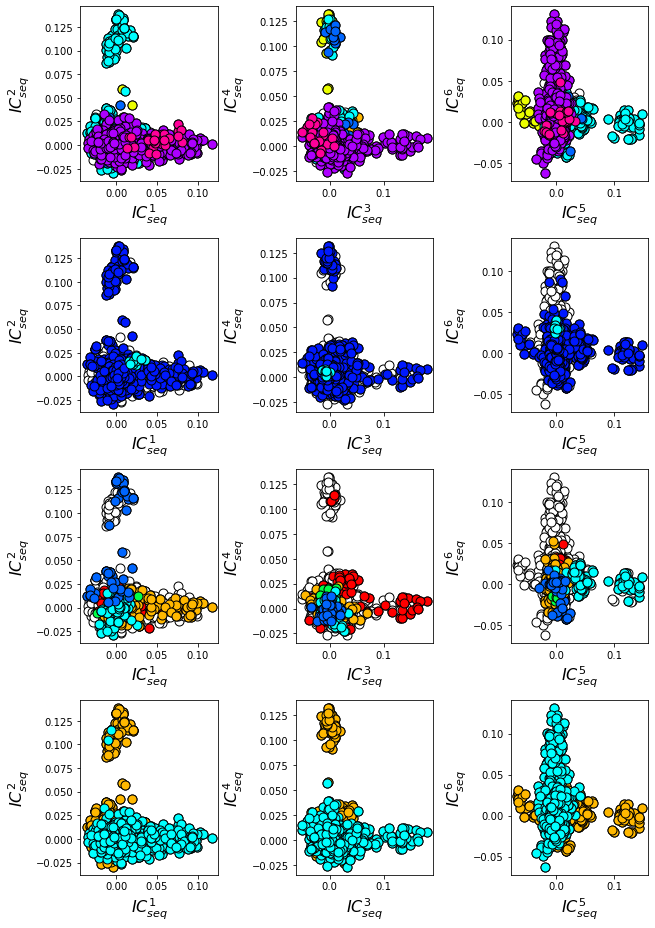

In [8]:
plt.rcParams['figure.figsize'] = 9, 13
U = Dsca['Uica'][1]
pairs = [[i, i+1] for i in range(0, 6, 2)]
for k,[k1,k2] in enumerate(pairs):
    plt.subplot(4,3,k+1)
    sca.figUnits(U[:,k1], U[:,k2], phylo)
    plt.xlabel(r"$IC_{seq}^{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"$IC_{seq}^{%i}$"%(k2+1), fontsize=16)
    plt.subplot(4,3,k+4)
    sca.figUnits(U[:,k1], U[:,k2], cat_classes)
    plt.xlabel(r"$IC_{seq}^{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"$IC_{seq}^{%i}$"%(k2+1), fontsize=16)
    plt.subplot(4,3,k+7)
    sca.figUnits(U[:,k1], U[:,k2], spec_classes)
    plt.xlabel(r"$IC_{seq}^{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"$IC_{seq}^{%i}$"%(k2+1), fontsize=16)
    plt.subplot(4,3,k+10)
    sca.figUnits(U[:,k1], U[:,k2], vert_classes)
    plt.xlabel(r"$IC_{seq}^{%i}$"%(k1+1), fontsize=16)
    plt.ylabel(r"$IC_{seq}^{%i}$"%(k2+1), fontsize=16)
plt.tight_layout()

### II. <u> First-order statistics: position-specific conservation.  <u/>

Plot the position-specific conservation values for each S1A protease position. $D_i$ is calculated according to equation S4 (supplemental information).

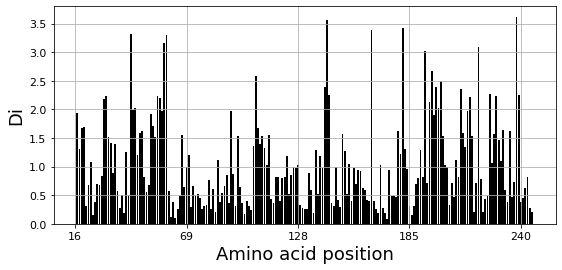

In [9]:
fig, axs = plt.subplots(1,1, figsize=(9,4))
xvals = [i+1 for i in range(len(Dsca['Di']))]
xticks = [0,50,100,150,200]
plt.bar(xvals,Dsca['Di'], color='k')
plt.tick_params(labelsize=11); plt.grid()
axs.set_xticks(xticks);
labels = [Dseq['ats'][k] for k in xticks]
axs.set_xticklabels(labels);
plt.xlabel('Amino acid position', fontsize=18); plt.ylabel('Di', fontsize=18);

### III. <u>Second-order statistics: conserved correlations.<u/>

Plot the SCA correlation matrix ( $\tilde{C_{ij}}$ ) computed according to Equations 4 + 5 of Rivoire et al.

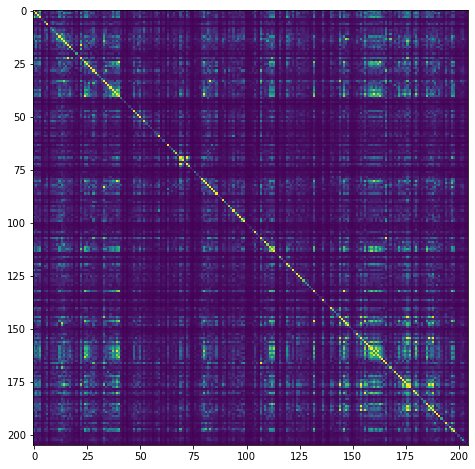

In [10]:
plt.rcParams['figure.figsize'] = 9, 8
plt.imshow(Dsca['Csca'], vmin=0, vmax=1.4,interpolation='none',\
           aspect='equal')

Plot the eigenspectrum of (1) the SCA positional coevolution matrix ($\tilde{C_{ij}}$) *(black bars)* and (2) 10 trials of matrix randomization for comparison. This graph is used to choose the number of significant eigenmodes ($k^* = 7$).

Number of eigenmodes to keep is 7


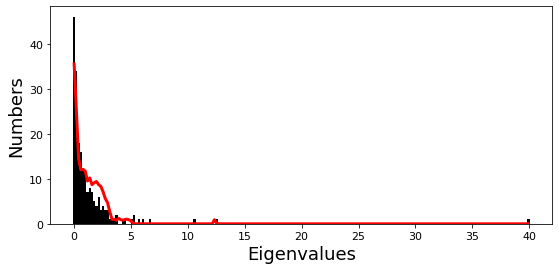

In [11]:
plt.rcParams['figure.figsize'] = 9, 4 
hist0, bins = np.histogram(Dsca['Lrand'].flatten(), bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
hist1, bins = np.histogram(Dsect['Lsca'], bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
plt.bar(bins[:-1], hist1, np.diff(bins),color='k')
plt.plot(bins[:-1], hist0/Dsca['Ntrials'], 'r', linewidth=3)
plt.tick_params(labelsize=11)
plt.xlabel('Eigenvalues', fontsize=18); plt.ylabel('Numbers', fontsize=18);
print('Number of eigenmodes to keep is %i' %(Dsect['kpos']))
#mpld3.display()

Plot the top significant eigenmodes *(top row)* and associated independent components *(bottom row)*. The ICs are an optimally independent representation of the seven different residue groups.

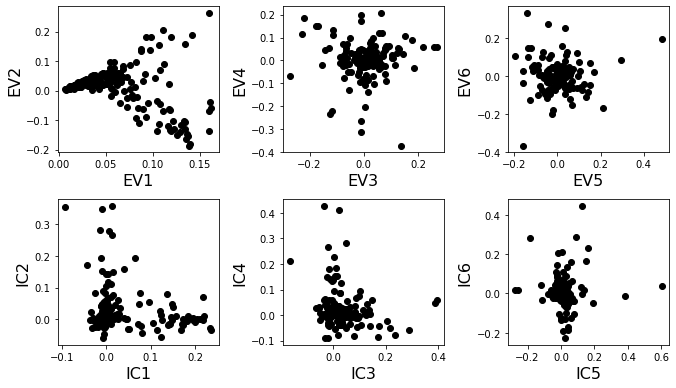

In [12]:
plt.rcParams['figure.figsize'] = 9.5, 5.5
EVs = Dsect['Vsca']
ICs = Dsect['Vpica']
pairs = [ [x,x+1] for x in range(0, Dsect['kpos']-1, 2)]
ncols = len(pairs)
for k,[k1,k2] in enumerate(pairs):
    plt.subplot(2,ncols,k+1)
    plt.plot(EVs[:,k1], EVs[:,k2], 'ok')
    plt.xlabel("EV%i"%(k1+1), fontsize=16)
    plt.ylabel("EV%i"%(k2+1), fontsize=16)
    plt.subplot(2,ncols,k+1+ncols)
    plt.plot(ICs[:,k1], ICs[:,k2], 'ok')
    plt.xlabel("IC%i"%(k1+1), fontsize=16)
    plt.ylabel("IC%i"%(k2+1), fontsize=16)
plt.tight_layout()

### IV. <u> Sector decomposition. <u/>

To define the positions with significant contributions to each of the independent components (ICs), we make a empirical fit for each IC to the t-distribution and select positions with greater than a specified cutoff on the CDF.  We choose $p=0.95$ as our cutoff.  Note that since some positions might contribute significantly to more than one IC (an indication of non-independence of ICs), we  apply a simple algorithm to assign such positions to one IC.  Specifically, we assign positions to the IC with which it has the greatest degree of co-evolution.In the case of IC7, all of the positions are more strongly assigned to other ICs, so we end up with 6 ICs containing 97 total positions<br/>

The data indicate generally good fits for the top seven ICs, and we return the positions contributing to each IC in a format suitable for cut and paste into PyMol.  

IC 1 is composed of 32 positions:
16+19+28+42+43+44+54+55+56+57+58+102+140+141+142+155+168+182+191+193+194+195+196+197+198+199+211+214+220+225+237+238

IC 2 is composed of 19 positions:
29+138+160+161+172+176+177+180+183+184+189+192+213+215+216+221+226+227+228

IC 3 is composed of 19 positions:
25+26+27+46+52+68+69+71+81+104+108+114+118+123+124+136+201+210+229

IC 4 is composed of 10 positions:
30+31+32+34+40+51+139+152+156+200

IC 5 is composed of 8 positions:
18+85+89+91+92+94+95+101

IC 6 is composed of 5 positions:
47+53+103+105+234

IC 7 is composed of 0 positions:




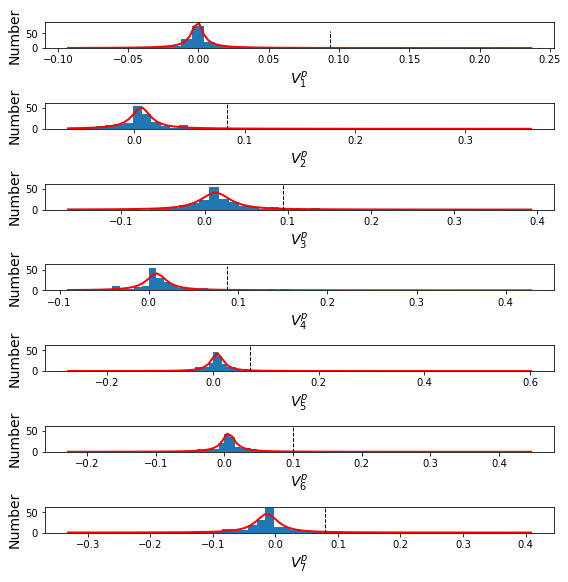

In [13]:
plt.rcParams['figure.figsize'] = 8, 8 

Vpica = Dsect['Vpica']
for k in range(Dsect['kpos']):
    iqr = scoreatpercentile(Vpica[:,k],75) - scoreatpercentile(Vpica[:,k],25)
    binwidth=2*iqr*(len(Vpica)**(-0.33))
    nbins=int(round((max(Vpica[:,k])-min(Vpica[:,k]))/binwidth))
    plt.subplot(Dsect['kpos'],1,k+1)
    h_params = plt.hist(Vpica[:,k], nbins)
    x_dist = np.linspace(min(h_params[1]), max(h_params[1]), num=100)
    plt.plot(x_dist,Dsect['scaled_pd'][k],'r',linewidth = 2)  
    plt.plot([Dsect['cutoff'][k],Dsect['cutoff'][k]], [0,60], 'k--',linewidth = 1)
    plt.xlabel(r'$V^p_{%i}$'%(k+1), fontsize=14)
    plt.ylabel('Number', fontsize=14)
plt.tight_layout()

for n,ipos in enumerate(Dsect['ics']):
    sort_ipos = sorted(ipos.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('IC %i is composed of %i positions:' % (n+1,len(ats_ipos)))
    print(ic_pymol + "\n")
        

To define protein sectors, we examine the structure of the SCA positional correlation matrix with positions contributing to the top  independent components (ICs) ordered by weight (*left panel*).  This provides a basis to determine/interpret which ICs are truly statistically independent (defining an independent sector) and which represent hierarchical breakdowns of one sector. In this case, the data suggest that ICs 1-7 are indeed relatively independent.   

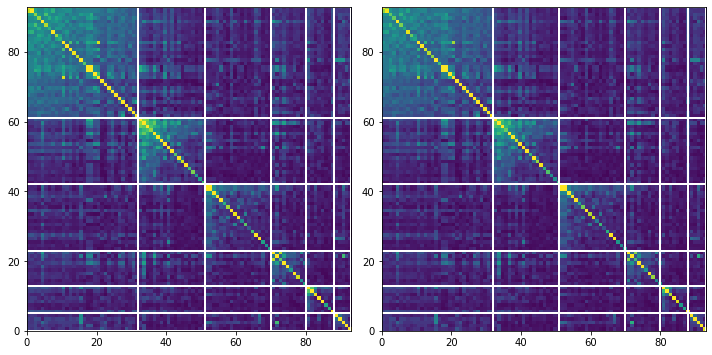

In [14]:
#plot the SCA positional correlation matrix, ordered by contribution to the top ICs
plt.rcParams['figure.figsize'] = 10, 10 
plt.subplot(121)
plt.imshow(Dsca['Csca'][np.ix_(Dsect['sortedpos'], Dsect['sortedpos'])], \
           vmin=0, vmax=2,interpolation='none',\
           aspect='equal',extent=[0,sum(Dsect['icsize']),\
                                  0,sum(Dsect['icsize'])])
line_index=0
for i in range(Dsect['kpos']):
    plt.plot([line_index+Dsect['icsize'][i],line_index+Dsect['icsize'][i]],\
             [0,sum(Dsect['icsize'])],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[sum(Dsect['icsize'])-\
            line_index,sum(Dsect['icsize'])-line_index],'w', linewidth = 2)
    line_index += Dsect['icsize'][i] 

#define the new sector groupings - 3 total
sec_groups = ([0],[1],[2],[3],[4],[5])
sectors = list()

#defining color codes for the sectors
#s1 = green, s2 = red, s3 = blue, s4 = orange, s5 = hot pink, s6 = cyan
c = [0.4,0,0.7,0.15,0.9,0.5] 
for n,k in enumerate(sec_groups):
    s = sca.Unit()
    all_items = list()
    all_Vp = list()
    for i in k: 
        all_items = all_items+Dsect['ics'][i].items
        all_Vp = all_Vp+list(Dsect['ics'][i].vect)
    svals = np.argsort(all_Vp)    
    s.items = [all_items[i] for i in svals]
    s.col = c[n]
    sectors.append(s)

#plot the re-ordered matrix
plt.subplot(122)
line_index=0
sortpos = list()
for s in sectors:
    sortpos.extend(s.items)
plt.imshow(Dsca['Csca'][np.ix_(sortpos, sortpos)], vmin=0, vmax=2.2,\
           interpolation='none',aspect='equal',\
           extent=[0,len(sortpos),0,len(sortpos)])
for s in sectors:
    plt.plot([line_index+len(s.items),line_index+len(s.items)],\
             [0,len(sortpos)],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[len(sortpos)-line_index,\
                    len(sortpos)-line_index],'w', linewidth = 2)
    line_index += len(s.items)
plt.tight_layout()

Print the sector positions, in a format suitable for pyMol, and create a pyMol session (in the output directory) with the sectors (and decomposition into independent components) as seperate objects.

In [15]:
for i,k in enumerate(sectors):
    sort_ipos = sorted(k.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('Sector %i is composed of %i positions:' % (i+1,len(ats_ipos)))
    print(ic_pymol + "\n")
sca.writePymol('3TGI', sectors, Dsect['ics'], Dseq['ats'], \
               '../output/S1A.pml','E', '../Inputs/', 0)  

Sector 1 is composed of 32 positions:
16+19+28+42+43+44+54+55+56+57+58+102+140+141+142+155+168+182+191+193+194+195+196+197+198+199+211+214+220+225+237+238

Sector 2 is composed of 19 positions:
29+138+160+161+172+176+177+180+183+184+189+192+213+215+216+221+226+227+228

Sector 3 is composed of 19 positions:
25+26+27+46+52+68+69+71+81+104+108+114+118+123+124+136+201+210+229

Sector 4 is composed of 10 positions:
30+31+32+34+40+51+139+152+156+200

Sector 5 is composed of 8 positions:
18+85+89+91+92+94+95+101

Sector 6 is composed of 5 positions:
47+53+103+105+234



These positions have clear physical consistency with the concept of sectors as functional, physically contiguous units in the protein structure. IC1 corresponds to the previously reported green sector, IC2 to the red sector, and IC3 is similar to the blue sector. ICs 4-6 follow the general principle of physical connectivity that seems to characterize sectors, but their functional meaning requires further study. 

### V. Sequence subfamilies and the basis of sector hierarchy.

How does the phylogenetic and functional heterogeneity in the MSA influence the sector definitions?  To address this, we take advantage of mathematical methods for mapping between the space of positional and sequence correlations, as described in *Rivoire et al* (see equations 8-11).  Using this mapping, we plot the top $k^*$ ICs of the matrix $\tilde{C_{ij}}$ as 2-D scatter plots *(top row)*, and compare them to the corresponding sequence space divergence *(middle and bottom rows)*.  The amino acid positions contributing to each IC are colored by sector *(sector 1 = green, sector 2 = red, sector 3 = blue, sector 4 = orange, sector 5 = pink, sector 6 = cyan, all top row)*. The sequences are color-coded according to phylogenetic classifications *(row 2)*, specificity *(row 3)*, vertebrate/invertebrate *(row 4)*, or catalytic activity *(row 5)* as we defined above. 

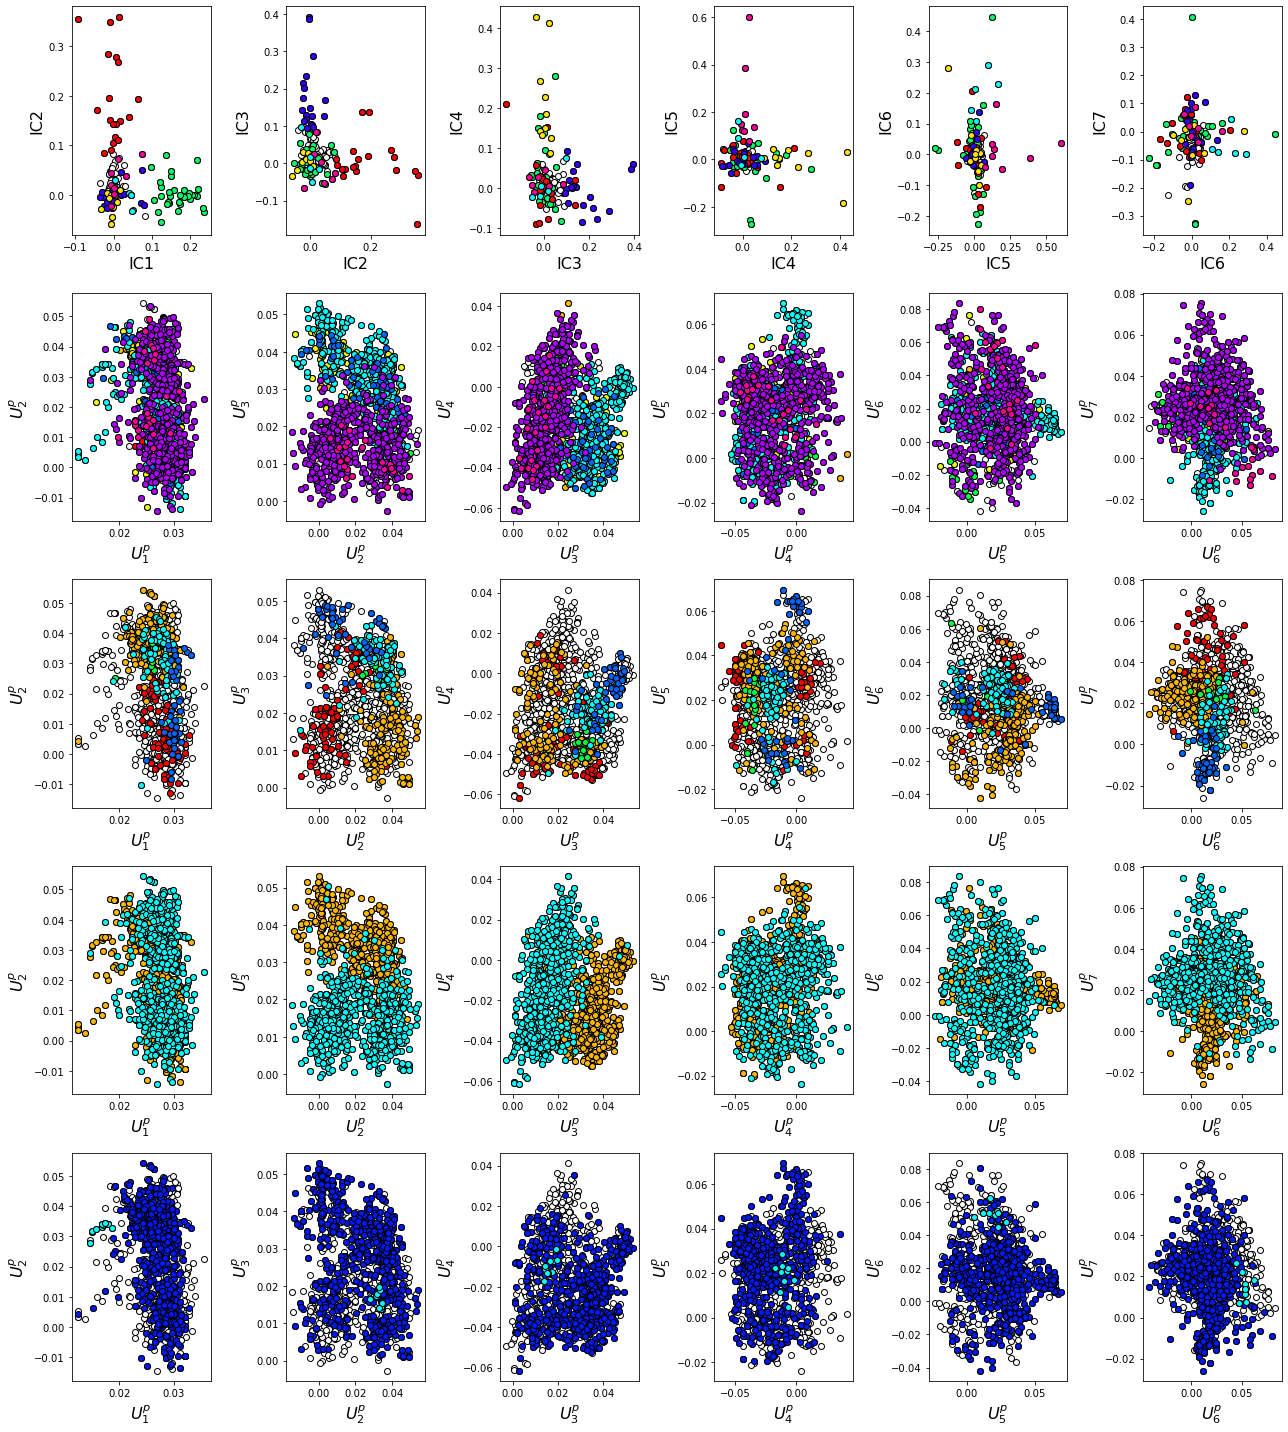

In [16]:
plt.rcParams['figure.figsize'] = 18, 20 
pairs = [ [x,x+1] for x in range(Dsect['kpos']-1)]
ncols = len(pairs)
for n,[k1,k2] in enumerate(pairs):
    plt.subplot(5,ncols,n+1)
    sca.figUnits(Dsect['Vpica'][:,k1], Dsect['Vpica'][:,k2], \
                 sectors, dotsize = 6)
    plt.xlabel('IC%i' % (k1+1), fontsize=16)
    plt.ylabel('IC%i' % (k2+1), fontsize=16)
    plt.subplot(5,ncols,n+1+ncols)
    sca.figUnits(Dsect['Upica'][:,k1], Dsect['Upica'][:,k2], \
                 phylo, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
    plt.subplot(5,ncols,n+1+ncols*2)
    sca.figUnits(Dsect['Upica'][:,k1], Dsect['Upica'][:,k2], \
                 spec_classes, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
    plt.subplot(5,ncols,n+1+ncols*3)
    sca.figUnits(Dsect['Upica'][:,k1], Dsect['Upica'][:,k2], \
                 vert_classes, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
    plt.subplot(5,ncols,n+1+ncols*4)
    sca.figUnits(Dsect['Upica'][:,k1], Dsect['Upica'][:,k2], \
                 cat_classes, dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
plt.tight_layout()

As previously described, we see a clear correpsondence between the top three sectors (red, green, blue) and distinct functional properties of the S1A protease family. IC1 *(the green sector)* seperates the non-catalytic haptoglobins *(cyan, bottom row)* from the catalytic family members. IC2 *(the red sector)* seperates the proteases by specificity, and IC3 *(the blue sector)* seperates vertebrate from invertebrate sequences. The remaining ICs (4-6) correspond to small numbers of physically contiguous positions, with no obvious relationship to particular sequence functional groups.

To more clearly see seperations in sequence classification, we also plot the above distributions of sequences as stacked bar plots.  

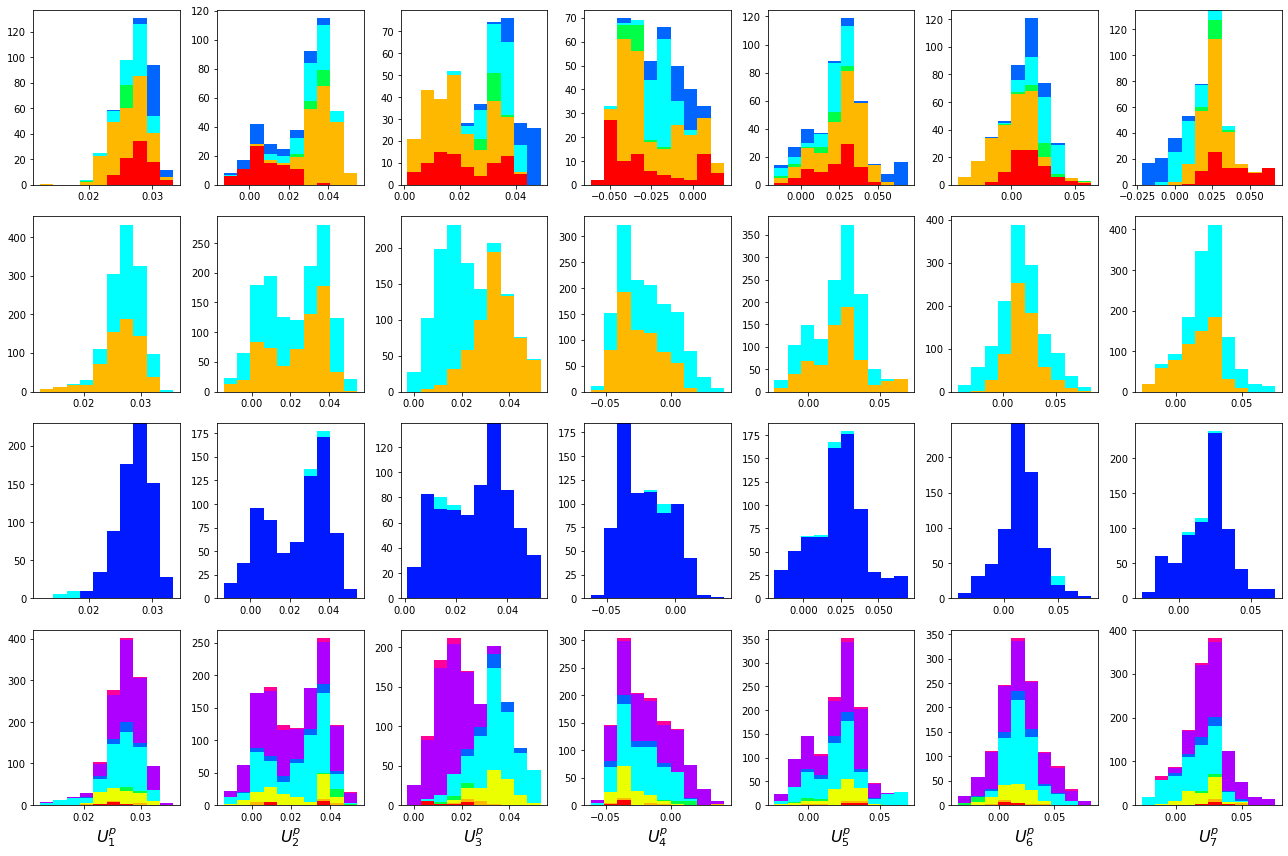

In [17]:
plt.rcParams['figure.figsize'] = 18, 12 

col = list()
for k in spec_classes:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in spec_classes:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.subplot(4,Dsect['kpos'],k+1)
    plt.hist(forhist, histtype='barstacked',color=col)
    
col = list()
for k in vert_classes:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in vert_classes:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.subplot(4,Dsect['kpos'],k+(Dsect['kpos'])+1)
    plt.hist(forhist, histtype='barstacked',color=col)

col = list()
for k in cat_classes:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in cat_classes:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.subplot(4,Dsect['kpos'],k+2*(Dsect['kpos'])+1)
    plt.hist(forhist, histtype='barstacked',color=col)

col = list()
for k in phylo:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect['kpos']):
    forhist = list()
    for group in phylo:
        forhist.append([Dsect['Upica'][i,k] for i in group.items])
    plt.subplot(4,Dsect['kpos'],k+(3*Dsect['kpos'])+1)
    plt.xlabel(r'$U^p_{%i}$' % (k+1), fontsize=16)
    plt.hist(forhist, histtype='barstacked',color=col)

plt.tight_layout()

This concludes the script.